## 5. Linear ensemble filtering Lorenz-96 problem with localization

In this notebook, we apply the stochastic ensemble Kalman filter to the Lorenz-96 problem.

To regularize the inference problem, we use a localization radius `L` to cut-off long-range correlations and improve the conditioning of the covariance matrix. We refers readers to Asch et al. [2] for further details.

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

[6] Evensen, G. (2003). The ensemble Kalman filter: Theoretical formulation and practical implementation. Ocean dynamics, 53(4), 343-367.

[7] Tsitouras, C. (2011). Runge–Kutta pairs of order 5 (4) satisfying only the first column simplifying assumption. Computers & Mathematics with Applications, 62(2), 770-775.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-96 model  is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing... The forty-dimensional state $\boldsymbol{x} = (x_1, \ldots, x_{40})$ at time $t$ is governed by the following set of ordinary differential equations: 
\begin{equation}
\label{eqn:lorenz96}
\frac{\mathrm{d} x_i}{\mathrm{d} t} = (x_{i+1} - x_{i-2}) x_{i-1} - x_{i} + F, \quad \mbox{for } i = 1, \ldots, 40,
\end{equation}
with periodic boundary conditions, setting the forcing input $F=8.0$ leads to chaos. We reproduce the hard configuration case of Spantini et al. [5]. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. We observe the state with $\Delta t_{obs}=0.4$, every two components ($x_1, x_3, x_5, \ldots, x_{39})$. The large time interval between two assimilation makes the problem particularly challenging and enhances the non-Gaussianity. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. We assume that there is no process noise. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_{20}$ where $\theta^2 = 0.5$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 40
Ny = 20

20

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.4

0.4

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

250

Define the properties of the initial condition

In [6]:
m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx);

We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching [7]. 

We assume that the state is fully observable, i.e. $h(t,x) = x$.

In [8]:
h(t,x) = x[2:2:end]
h(t,x,idx) = x[idx]

F = StateSpace(lorenz96!, h)

StateSpace(AdaptiveTransportMap.lorenz96!, h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample form the likelihood.

`ϵy` defines the additive observation noise. 

We assume that these noises have Gaussian distribution.

In [34]:
σx = 1e-16
σy = 0.5

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.25 0.0 … 0.0 0.0; 0.0 0.25 … 0.0 0.0; … ; 0.0 0.0 … 0.25 0.0; 0.0 0.0 … 0.0 0.25], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5])

In [35]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, F);

Set initial condition of the true system

In [36]:
x0 = model.m0 + sqrt(model.C0)*randn(Nx);

Run dynamics and generate data

In [37]:
@time data = generate_lorenz96(model, x0, Tf);

  0.005344 seconds (19.17 k allocations: 3.892 MiB)


Define a stochastic ensemble Kalman filter

In [38]:
senkf = StochEnKF(model.ϵy, model.Δtdyn, model.Δtobs)

Stochastic EnKF  with filtered = false


Define a ensemble transform Kalman filter

In [39]:
etkf = ETKF(model.ϵy, model.Δtdyn, model.Δtobs, 20*model.Δtobs)

ETKF  with filtered = false


Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [40]:
Ne = 100 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0;

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

Without localization

In [41]:
@time Xsenkf = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

  0.984651 seconds (2.00 M allocations: 440.674 MiB, 12.74% gc time)


Localization can easily be added as an additional regularization of the analysis step as follows....

In [42]:
@time Xsenkfloc = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

  0.922576 seconds (2.00 M allocations: 440.674 MiB, 8.93% gc time)


`mean_hist` stacked together the ensemble mean over the assimilation window.

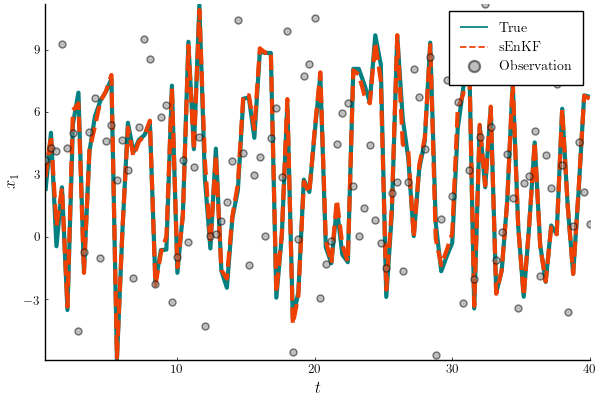

In [43]:
# Plot the first component of the state over time
nb = 1
ne = 100#size(Xsenkf,1)-1
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

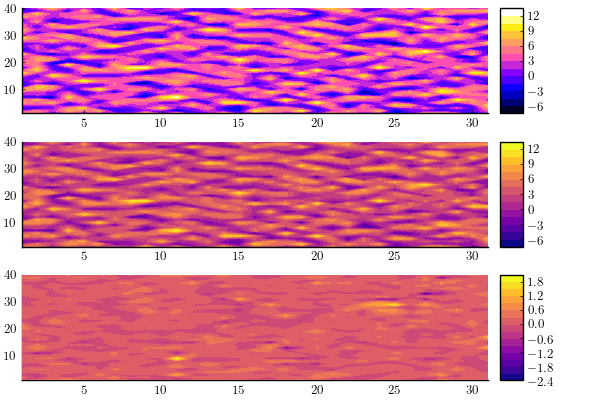

In [50]:
nb = 100
ne = size(Xsenkf,1)-1
Δ = 5

plt = plot(layout = grid(3,1))
contourf!(plt[1,1], data.xt[:,nb:Δ:ne], color = :gnuplot2)
contourf!(plt[2,1], mean_hist(Xsenkf)[:,1+nb:Δ:1+ne], color = :plasma)
contourf!(plt[3,1], mean_hist(Xsenkf)[:,1+nb:Δ:1+ne] .- data.xt[:,nb:Δ:ne], color = :plasma)

In [25]:
# Plot the different component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsenkf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mUndefVarError: Xsenkf not defined[39m